In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,KFold
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score,f1_score,confusion_matrix
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
import string
from collections import defaultdict
from scipy.sparse import csr_matrix, hstack
from spellchecker import SpellChecker

import tensorflow_hub as hub
import lightgbm as lgb
pd.set_option('max_colwidth',300)

參考 https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove   
參考 https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert

# EDA

In [4]:
train = pd.read_csv(r'C:\Users\User\Dropbox\Kaggle\NLP with Disaster Tweets\train.csv')
test = pd.read_csv(r'C:\Users\User\Dropbox\Kaggle\NLP with Disaster Tweets\test.csv')

Text(0, 0.5, 'samples')

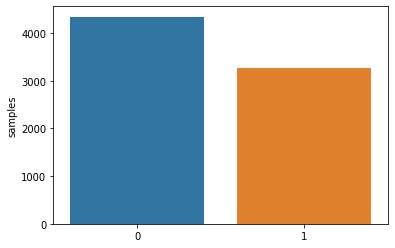

In [72]:
x=train.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

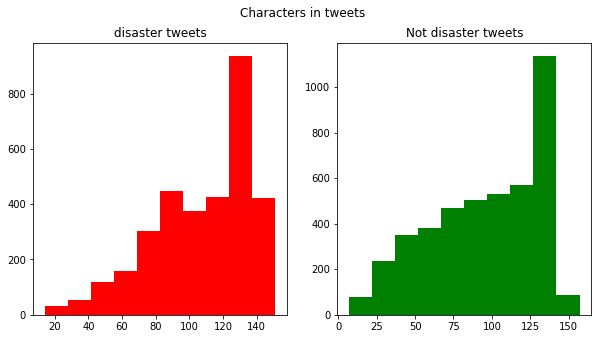

In [74]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
train_len=train[train['target']==1]['text'].str.len()
ax1.hist(train_len,color='red')
ax1.set_title('disaster tweets')
train_len=train[train['target']==0]['text'].str.len()
ax2.hist(train_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

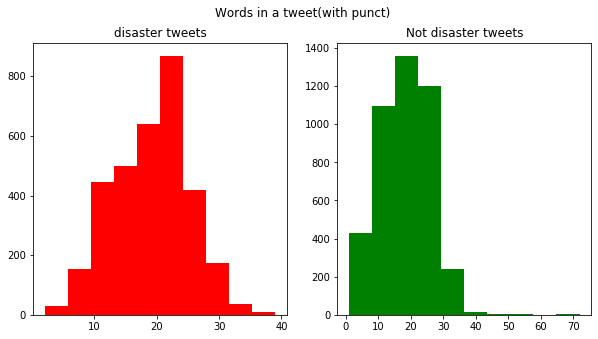

In [78]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
train_len=train[train['target']==1]['text'].map(lambda x: len(nltk.word_tokenize(x)))
ax1.hist(train_len,color='red')
ax1.set_title('disaster tweets')
train_len=train[train['target']==0]['text'].map(lambda x: len(nltk.word_tokenize(x)))
ax2.hist(train_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet(with punct)')
plt.show()

In [79]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

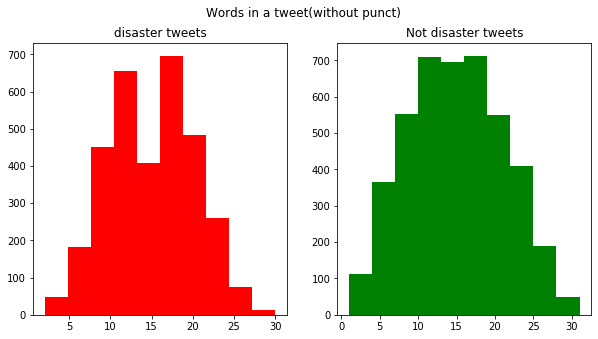

In [80]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
train_len=train[train['target']==1]['text'].map(lambda x: len(nltk.word_tokenize(remove_punct(x))))
ax1.hist(train_len,color='red')
ax1.set_title('disaster tweets')
train_len=train[train['target']==0]['text'].map(lambda x: len(nltk.word_tokenize(remove_punct(x))))
ax2.hist(train_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet(without punct)')
plt.show()

Text(0.5, 0.98, 'Average word length in each tweet')

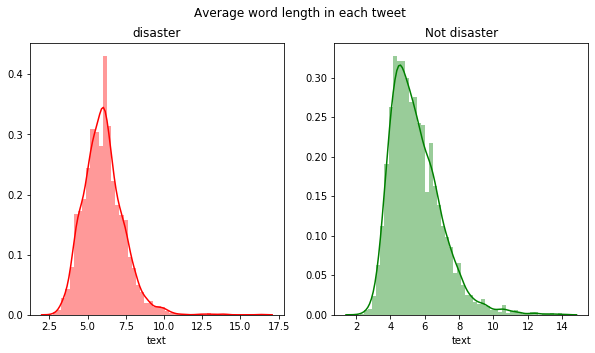

In [81]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=train[train['target']==1]['text'].apply(lambda x:[len(i) for i in nltk.word_tokenize(remove_punct(x))])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('disaster')
word=train[train['target']==0]['text'].apply(lambda x:[len(i) for i in nltk.word_tokenize(remove_punct(x))])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

In [110]:
def create_corpus(target):
    corpus=[]
    stop=set(stopwords.words('english'))
    for x in train[train['target']==target]['text'].apply(lambda x: nltk.word_tokenize(remove_punct(x))):
        for i in x:
            i=i.lower()
            if i in stop:
                pass
            else:
                corpus.append(i)
    return corpus

Text(0.5, 1.0, 'Not disaster most frequent words')

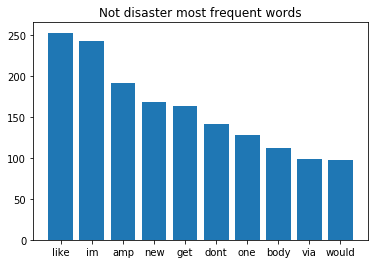

In [116]:
corpus=create_corpus(0)
tokens_dist = FreqDist(corpus)
tokens_dist_sorted = dict(sorted(tokens_dist.items(), key=lambda e: e[1],reverse=True))
vocab = list(tokens_dist_sorted.keys()) 
x = vocab[:10]
y = []
for i in x:
    y.append(tokens_dist_sorted.get(i))
plt.bar(x,y)
plt.title('Not disaster most frequent words')

Text(0.5, 1.0, 'Disaster most frequent words')

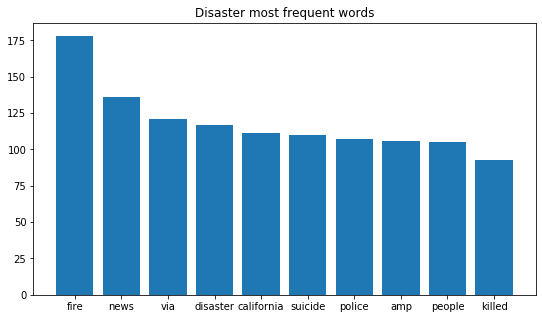

In [121]:
corpus=create_corpus(1)
tokens_dist = FreqDist(corpus)
tokens_dist_sorted = dict(sorted(tokens_dist.items(), key=lambda e: e[1],reverse=True))
vocab = list(tokens_dist_sorted.keys()) 
x = vocab[:10]
y = []
for i in x:
    y.append(tokens_dist_sorted.get(i))
plt.figure(figsize=(9,5))
plt.bar(x,y)
plt.title('Disaster most frequent words')

In [122]:
def create_raw_corpus(target):
    return train[train['target']==target]['text'].apply(lambda x: remove_punct(x))

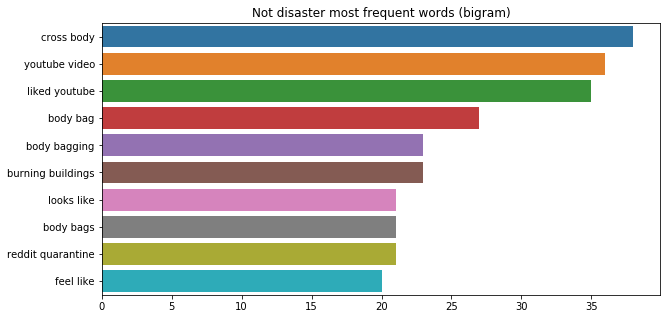

In [130]:
corpus=create_raw_corpus(0)
vect = CountVectorizer(stop_words='english',ngram_range=(2,2),token_pattern='(?u)\\b\\w\\w\\w+\\b').fit(corpus)
bigram_words = vect.transform(corpus)
sum_bigram_words = bigram_words.sum(axis=0) 
words_freq = [(word, sum_bigram_words[0, idx]) for word, idx in vect.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
plt.figure(figsize=(10,5))
top_tweet_bigrams=words_freq[:10]
x,y=map(list,zip(*top_tweet_bigrams))
plt.title('Not disaster most frequent words (bigram)')
sns.barplot(x=y,y=x)

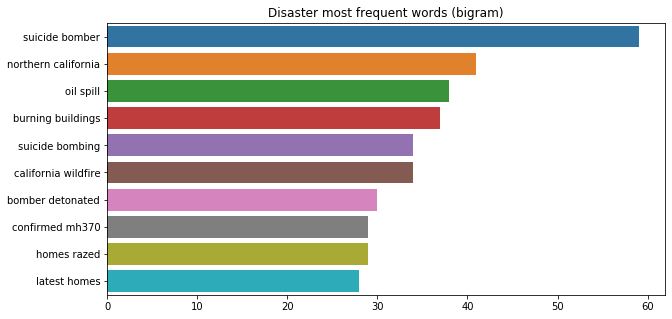

In [131]:
corpus=create_raw_corpus(1)
vect = CountVectorizer(stop_words='english',ngram_range=(2,2),token_pattern='(?u)\\b\\w\\w\\w+\\b').fit(corpus)
bigram_words = vect.transform(corpus)
sum_bigram_words = bigram_words.sum(axis=0) 
words_freq = [(word, sum_bigram_words[0, idx]) for word, idx in vect.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
plt.figure(figsize=(10,5))
top_tweet_bigrams=words_freq[:10]
x,y=map(list,zip(*top_tweet_bigrams))
plt.title('Disaster most frequent words (bigram)')
sns.barplot(x=y,y=x)

# Data Preprocess
I combined various text cleaning techniques from other notebooks into this one. The original source of each technique is credited alongside the relevant block of code. Features include:

 * Expands contractions (can't = cannot)
 * Expands tweet slang (OMG = Oh My God)
 * Removes emojis
 * Removes HTML tags
 * Removes URLs
 * Replaces repeated punctuation with a single character (Wow!!!!! = Wow!)
 * Removes special characters
 * Optionally removes common English stopwords
 * Optionally lemmatizes words, converts plural and conjugated words into a single root (corpora = corpus, rocks = rock)
 * Optionally corrects common mispellings

In [2]:
# https://stackoverflow.com/a/34682849
def untokenize(words):
    """Untokenizing a text undoes the tokenizing operation, restoring
    punctuation and spaces to the places that people expect them to be.
    Ideally, `untokenize(tokenize(text))` should be identical to `text`,
    except for line breaks.
    """
    text = ' '.join(words)
    step1 = text.replace("`` ", '"').replace(" ''", '"').replace('. . .', '...')
    step2 = step1.replace(" ( ", " (").replace(" ) ", ") ")
    step3 = re.sub(r' ([.,:;?!%]+)([ \'"`])', r"\1\2", step2)
    step4 = re.sub(r' ([.,:;?!%]+)$', r"\1", step3)
    step5 = step4.replace(" '", "'").replace(" n't", "n't").replace(
        "can not", "cannot")
    step6 = step5.replace(" ` ", " '")
    return step6.strip()


# https://stackoverflow.com/a/47091490
def decontracted(phrase):
    """Convert contractions like "can't" into "can not"
    """
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    #phrase = re.sub(r"n't", " not", phrase) # resulted in "ca not" when sentence started with "can't"
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"[Hh]e\'s", "He is", phrase)
    phrase = re.sub(r"[Ss]he\'s", "She is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


# https://github.com/rishabhverma17/sms_slang_translator/blob/master/slang.txt
slang_abbrev_dict = {
    'AFAIK': 'As Far As I Know',
    'AFK': 'Away From Keyboard',
    'ASAP': 'As Soon As Possible',
    'ATK': 'At The Keyboard',
    'ATM': 'At The Moment',
    'A3': 'Anytime, Anywhere, Anyplace',
    'BAK': 'Back At Keyboard',
    'BBL': 'Be Back Later',
    'BBS': 'Be Back Soon',
    'BFN': 'Bye For Now',
    'B4N': 'Bye For Now',
    'BRB': 'Be Right Back',
    'BRT': 'Be Right There',
    'BTW': 'By The Way',
    'B4': 'Before',
    'B4N': 'Bye For Now',
    'CU': 'See You',
    'CUL8R': 'See You Later',
    'CYA': 'See You',
    'FAQ': 'Frequently Asked Questions',
    'FC': 'Fingers Crossed',
    'FWIW': 'For What It\'s Worth',
    'FYI': 'For Your Information',
    'GAL': 'Get A Life',
    'GG': 'Good Game',
    'GN': 'Good Night',
    'GMTA': 'Great Minds Think Alike',
    'GR8': 'Great!',
    'G9': 'Genius',
    'IC': 'I See',
    'ICQ': 'I Seek you',
    'ILU': 'I Love You',
    'IMHO': 'In My Humble Opinion',
    'IMO': 'In My Opinion',
    'IOW': 'In Other Words',
    'IRL': 'In Real Life',
    'KISS': 'Keep It Simple, Stupid',
    'LDR': 'Long Distance Relationship',
    'LMAO': 'Laugh My Ass Off',
    'LOL': 'Laughing Out Loud',
    'LTNS': 'Long Time No See',
    'L8R': 'Later',
    'MTE': 'My Thoughts Exactly',
    'M8': 'Mate',
    'NRN': 'No Reply Necessary',
    'OIC': 'Oh I See',
    'OMG': 'Oh My God',
    'PITA': 'Pain In The Ass',
    'PRT': 'Party',
    'PRW': 'Parents Are Watching',
    'QPSA?': 'Que Pasa?',
    'ROFL': 'Rolling On The Floor Laughing',
    'ROFLOL': 'Rolling On The Floor Laughing Out Loud',
    'ROTFLMAO': 'Rolling On The Floor Laughing My Ass Off',
    'SK8': 'Skate',
    'STATS': 'Your sex and age',
    'ASL': 'Age, Sex, Location',
    'THX': 'Thank You',
    'TTFN': 'Ta-Ta For Now!',
    'TTYL': 'Talk To You Later',
    'U': 'You',
    'U2': 'You Too',
    'U4E': 'Yours For Ever',
    'WB': 'Welcome Back',
    'WTF': 'What The Fuck',
    'WTG': 'Way To Go!',
    'WUF': 'Where Are You From?',
    'W8': 'Wait',
    '7K': 'Sick:-D Laugher'
}


def unslang(text):
    """Converts text like "OMG" into "Oh my God"
    """
    if text.upper() in slang_abbrev_dict.keys():
        return slang_abbrev_dict[text.upper()]
    else:
        return text


# https://gist.github.com/sebleier/554280
stopwords = [
    "a", "about", "above", "after", "again", "against", "ain", "all", "am",
    "an", "and", "any", "are", "aren", "aren't", "as", "at", "be", "because",
    "been", "before", "being", "below", "between", "both", "but", "by", "can",
    "couldn", "couldn't", "d", "did", "didn", "didn't", "do", "does", "doesn",
    "doesn't", "doing", "don", "don't", "down", "during", "each", "few", "for",
    "from", "further", "had", "hadn", "hadn't", "has", "hasn", "hasn't", "have",
    "haven", "haven't", "having", "he", "her", "here", "hers", "herself", "him",
    "himself", "his", "how", "i", "if", "in", "into", "is", "isn", "isn't",
    "it", "it's", "its", "itself", "just", "ll", "m", "ma", "me", "mightn",
    "mightn't", "more", "most", "mustn", "mustn't", "my", "myself", "needn",
    "needn't", "no", "nor", "not", "now", "o", "of", "off", "on", "once",
    "only", "or", "other", "our", "ours", "ourselves", "out", "over", "own",
    "re", "s", "same", "shan", "shan't", "she", "she's", "should", "should've",
    "shouldn", "shouldn't", "so", "some", "such", "t", "than", "that",
    "that'll", "the", "their", "theirs", "them", "themselves", "then", "there",
    "these", "they", "this", "those", "through", "to", "too", "under", "until",
    "up", "ve", "very", "was", "wasn", "wasn't", "we", "were", "weren",
    "weren't", "what", "when", "where", "which", "while", "who", "whom", "why",
    "will", "with", "won", "won't", "wouldn", "wouldn't", "y", "you", "you'd",
    "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves",
    "could", "he'd", "he'll", "he's", "here's", "how's", "i'd", "i'll", "i'm",
    "i've", "let's", "ought", "she'd", "she'll", "that's", "there's", "they'd",
    "they'll", "they're", "they've", "we'd", "we'll", "we're", "we've",
    "what's", "when's", "where's", "who's", "why's", "would", "able", "abst",
    "accordance", "according", "accordingly", "across", "act", "actually",
    "added", "adj", "affected", "affecting", "affects", "afterwards", "ah",
    "almost", "alone", "along", "already", "also", "although", "always",
    "among", "amongst", "announce", "another", "anybody", "anyhow", "anymore",
    "anyone", "anything", "anyway", "anyways", "anywhere", "apparently",
    "approximately", "arent", "arise", "around", "aside", "ask", "asking",
    "auth", "available", "away", "awfully", "b", "back", "became", "become",
    "becomes", "becoming", "beforehand", "begin", "beginning", "beginnings",
    "begins", "behind", "believe", "beside", "besides", "beyond", "biol",
    "brief", "briefly", "c", "ca", "came", "cannot", "can't", "cause", "causes",
    "certain", "certainly", "co", "com", "come", "comes", "contain",
    "containing", "contains", "couldnt", "date", "different", "done",
    "downwards", "due", "e", "ed", "edu", "effect", "eg", "eight", "eighty",
    "either", "else", "elsewhere", "end", "ending", "enough", "especially",
    "et", "etc", "even", "ever", "every", "everybody", "everyone", "everything",
    "everywhere", "ex", "except", "f", "far", "ff", "fifth", "first", "five",
    "fix", "followed", "following", "follows", "former", "formerly", "forth",
    "found", "four", "furthermore", "g", "gave", "get", "gets", "getting",
    "give", "given", "gives", "giving", "go", "goes", "gone", "got", "gotten",
    "h", "happens", "hardly", "hed", "hence", "hereafter", "hereby", "herein",
    "heres", "hereupon", "hes", "hi", "hid", "hither", "home", "howbeit",
    "however", "hundred", "id", "ie", "im", "immediate", "immediately",
    "importance", "important", "inc", "indeed", "index", "information",
    "instead", "invention", "inward", "itd", "it'll", "j", "k", "keep", "keeps",
    "kept", "kg", "km", "know", "known", "knows", "l", "largely", "last",
    "lately", "later", "latter", "latterly", "least", "less", "lest", "let",
    "lets", "like", "liked", "likely", "line", "little", "'ll", "look",
    "looking", "looks", "ltd", "made", "mainly", "make", "makes", "many", "may",
    "maybe", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might",
    "million", "miss", "ml", "moreover", "mostly", "mr", "mrs", "much", "mug",
    "must", "n", "na", "name", "namely", "nay", "nd", "near", "nearly",
    "necessarily", "necessary", "need", "needs", "neither", "never",
    "nevertheless", "new", "next", "nine", "ninety", "nobody", "non", "none",
    "nonetheless", "noone", "normally", "nos", "noted", "nothing", "nowhere",
    "obtain", "obtained", "obviously", "often", "oh", "ok", "okay", "old",
    "omitted", "one", "ones", "onto", "ord", "others", "otherwise", "outside",
    "overall", "owing", "p", "page", "pages", "part", "particular",
    "particularly", "past", "per", "perhaps", "placed", "please", "plus",
    "poorly", "possible", "possibly", "potentially", "pp", "predominantly",
    "present", "previously", "primarily", "probably", "promptly", "proud",
    "provides", "put", "q", "que", "quickly", "quite", "qv", "r", "ran",
    "rather", "rd", "readily", "really", "recent", "recently", "ref", "refs",
    "regarding", "regardless", "regards", "related", "relatively", "research",
    "respectively", "resulted", "resulting", "results", "right", "run", "said",
    "saw", "say", "saying", "says", "sec", "section", "see", "seeing", "seem",
    "seemed", "seeming", "seems", "seen", "self", "selves", "sent", "seven",
    "several", "shall", "shed", "shes", "show", "showed", "shown", "showns",
    "shows", "significant", "significantly", "similar", "similarly", "since",
    "six", "slightly", "somebody", "somehow", "someone", "somethan",
    "something", "sometime", "sometimes", "somewhat", "somewhere", "soon",
    "sorry", "specifically", "specified", "specify", "specifying", "still",
    "stop", "strongly", "sub", "substantially", "successfully", "sufficiently",
    "suggest", "sup", "sure", "take", "taken", "taking", "tell", "tends", "th",
    "thank", "thanks", "thanx", "thats", "that've", "thence", "thereafter",
    "thereby", "thered", "therefore", "therein", "there'll", "thereof",
    "therere", "theres", "thereto", "thereupon", "there've", "theyd", "theyre",
    "think", "thou", "though", "thoughh", "thousand", "throug", "throughout",
    "thru", "thus", "til", "tip", "together", "took", "toward", "towards",
    "tried", "tries", "truly", "try", "trying", "ts", "twice", "two", "u", "un",
    "unfortunately", "unless", "unlike", "unlikely", "unto", "upon", "ups",
    "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using",
    "usually", "v", "value", "various", "'ve", "via", "viz", "vol", "vols",
    "vs", "w", "want", "wants", "wasnt", "way", "wed", "welcome", "went",
    "werent", "whatever", "what'll", "whats", "whence", "whenever",
    "whereafter", "whereas", "whereby", "wherein", "wheres", "whereupon",
    "wherever", "whether", "whim", "whither", "whod", "whoever", "whole",
    "who'll", "whomever", "whos", "whose", "widely", "willing", "wish",
    "within", "without", "wont", "words", "world", "wouldnt", "www", "x", "yes",
    "yet", "youd", "youre", "z", "zero", "a's", "ain't", "allow", "allows",
    "apart", "appear", "appreciate", "appropriate", "associated", "best",
    "better", "c'mon", "c's", "cant", "changes", "clearly", "concerning",
    "consequently", "consider", "considering", "corresponding", "course",
    "currently", "definitely", "described", "despite", "entirely", "exactly",
    "example", "going", "greetings", "hello", "help", "hopefully", "ignored",
    "inasmuch", "indicate", "indicated", "indicates", "inner", "insofar",
    "it'd", "keep", "keeps", "novel", "presumably", "reasonably", "second",
    "secondly", "sensible", "serious", "seriously", "sure", "t's", "third",
    "thorough", "thoroughly", "three", "well", "wonder", "a", "about", "above",
    "above", "across", "after", "afterwards", "again", "against", "all",
    "almost", "alone", "along", "already", "also", "although", "always", "am",
    "among", "amongst", "amoungst", "amount", "an", "and", "another", "any",
    "anyhow", "anyone", "anything", "anyway", "anywhere", "are", "around", "as",
    "at", "back", "be", "became", "because", "become", "becomes", "becoming",
    "been", "before", "beforehand", "behind", "being", "below", "beside",
    "besides", "between", "beyond", "bill", "both", "bottom", "but", "by",
    "call", "can", "cannot", "cant", "co", "con", "could", "couldnt", "cry",
    "de", "describe", "detail", "do", "done", "down", "due", "during", "each",
    "eg", "eight", "either", "eleven", "else", "elsewhere", "empty", "enough",
    "etc", "even", "ever", "every", "everyone", "everything", "everywhere",
    "except", "few", "fifteen", "fify", "fill", "find", "fire", "first", "five",
    "for", "former", "formerly", "forty", "found", "four", "from", "front",
    "full", "further", "get", "give", "go", "had", "has", "hasnt", "have", "he",
    "hence", "her", "here", "hereafter", "hereby", "herein", "hereupon", "hers",
    "herself", "him", "himself", "his", "how", "however", "hundred", "ie", "if",
    "in", "inc", "indeed", "interest", "into", "is", "it", "its", "itself",
    "keep", "last", "latter", "latterly", "least", "less", "ltd", "made",
    "many", "may", "me", "meanwhile", "might", "mill", "mine", "more",
    "moreover", "most", "mostly", "move", "much", "must", "my", "myself",
    "name", "namely", "neither", "never", "nevertheless", "next", "nine", "no",
    "nobody", "none", "noone", "nor", "not", "nothing", "now", "nowhere", "of",
    "off", "often", "on", "once", "one", "only", "onto", "or", "other",
    "others", "otherwise", "our", "ours", "ourselves", "out", "over", "own",
    "part", "per", "perhaps", "please", "put", "rather", "re", "same", "see",
    "seem", "seemed", "seeming", "seems", "serious", "several", "she", "should",
    "show", "side", "since", "sincere", "six", "sixty", "so", "some", "somehow",
    "someone", "something", "sometime", "sometimes", "somewhere", "still",
    "such", "system", "take", "ten", "than", "that", "the", "their", "them",
    "themselves", "then", "thence", "there", "thereafter", "thereby",
    "therefore", "therein", "thereupon", "these", "they", "thickv", "thin",
    "third", "this", "those", "though", "three", "through", "throughout",
    "thru", "thus", "to", "together", "too", "top", "toward", "towards",
    "twelve", "twenty", "two", "un", "under", "until", "up", "upon", "us",
    "very", "via", "was", "we", "well", "were", "what", "whatever", "when",
    "whence", "whenever", "where", "whereafter", "whereas", "whereby",
    "wherein", "whereupon", "wherever", "whether", "which", "while", "whither",
    "who", "whoever", "whole", "whom", "whose", "why", "will", "with", "within",
    "without", "would", "yet", "you", "your", "yours", "yourself", "yourselves",
    "the", "a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n",
    "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z", "A", "B", "C",
    "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R",
    "S", "T", "U", "V", "W", "X", "Y", "Z", "co", "op", "research-articl",
    "pagecount", "cit", "ibid", "les", "le", "au", "que", "est", "pas", "vol",
    "el", "los", "pp", "u201d", "well-b", "http", "volumtype", "par", "0o",
    "0s", "3a", "3b", "3d", "6b", "6o", "a1", "a2", "a3", "a4", "ab", "ac",
    "ad", "ae", "af", "ag", "aj", "al", "an", "ao", "ap", "ar", "av", "aw",
    "ax", "ay", "az", "b1", "b2", "b3", "ba", "bc", "bd", "be", "bi", "bj",
    "bk", "bl", "bn", "bp", "br", "bs", "bt", "bu", "bx", "c1", "c2", "c3",
    "cc", "cd", "ce", "cf", "cg", "ch", "ci", "cj", "cl", "cm", "cn", "cp",
    "cq", "cr", "cs", "ct", "cu", "cv", "cx", "cy", "cz", "d2", "da", "dc",
    "dd", "de", "df", "di", "dj", "dk", "dl", "do", "dp", "dr", "ds", "dt",
    "du", "dx", "dy", "e2", "e3", "ea", "ec", "ed", "ee", "ef", "ei", "ej",
    "el", "em", "en", "eo", "ep", "eq", "er", "es", "et", "eu", "ev", "ex",
    "ey", "f2", "fa", "fc", "ff", "fi", "fj", "fl", "fn", "fo", "fr", "fs",
    "ft", "fu", "fy", "ga", "ge", "gi", "gj", "gl", "go", "gr", "gs", "gy",
    "h2", "h3", "hh", "hi", "hj", "ho", "hr", "hs", "hu", "hy", "i", "i2", "i3",
    "i4", "i6", "i7", "i8", "ia", "ib", "ic", "ie", "ig", "ih", "ii", "ij",
    "il", "in", "io", "ip", "iq", "ir", "iv", "ix", "iy", "iz", "jj", "jr",
    "js", "jt", "ju", "ke", "kg", "kj", "km", "ko", "l2", "la", "lb", "lc",
    "lf", "lj", "ln", "lo", "lr", "ls", "lt", "m2", "ml", "mn", "mo", "ms",
    "mt", "mu", "n2", "nc", "nd", "ne", "ng", "ni", "nj", "nl", "nn", "nr",
    "ns", "nt", "ny", "oa", "ob", "oc", "od", "of", "og", "oi", "oj", "ol",
    "om", "on", "oo", "oq", "or", "os", "ot", "ou", "ow", "ox", "oz", "p1",
    "p2", "p3", "pc", "pd", "pe", "pf", "ph", "pi", "pj", "pk", "pl", "pm",
    "pn", "po", "pq", "pr", "ps", "pt", "pu", "py", "qj", "qu", "r2", "ra",
    "rc", "rd", "rf", "rh", "ri", "rj", "rl", "rm", "rn", "ro", "rq", "rr",
    "rs", "rt", "ru", "rv", "ry", "s2", "sa", "sc", "sd", "se", "sf", "si",
    "sj", "sl", "sm", "sn", "sp", "sq", "sr", "ss", "st", "sy", "sz", "t1",
    "t2", "t3", "tb", "tc", "td", "te", "tf", "th", "ti", "tj", "tl", "tm",
    "tn", "tp", "tq", "tr", "ts", "tt", "tv", "tx", "ue", "ui", "uj", "uk",
    "um", "un", "uo", "ur", "ut", "va", "wa", "vd", "wi", "vj", "vo", "wo",
    "vq", "vt", "vu", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn",
    "xo", "xs", "xt", "xv", "xx", "y2", "yj", "yl", "yr", "ys", "yt", "zi", "zz"
]


# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


# from: https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove
# maybe a bug, it removes question marks?
spell = SpellChecker()

def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

def remove_urls(text):
    text = clean(r"http\S+", text)
    text = clean(r"www\S+", text)
    text = clean(r"pic.twitter.com\S+", text)

    return text

def clean(reg_exp, text):
    text = re.sub(reg_exp, " ", text)

    # replace multiple spaces with one.
    text = re.sub('\s{2,}', ' ', text)

    return text

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

lemmatizer = WordNetLemmatizer()

def clean_all(t, correct_spelling=False, remove_stopwords=False, lemmatize=False):
    
    # first do bulk cleanup on tokens that don't depend on word tokenization

    # remove xml tags
    t = clean(r"<[^>]+>", t)
    t = clean(r"&lt;", t)
    t = clean(r"&gt;", t)

    # remove URLs
    t = remove_urls(t)

    # https://stackoverflow.com/a/35041925
    # replace multiple punctuation with single. Ex: !?!?!? would become ?
    t = clean(r'[\?\.\!]+(?=[\?\.\!])', t)

    t = remove_emoji(t)

    # expand common contractions like "I'm" "he'll"
    t = decontracted(t)

    # now remove/expand bad patterns per word
    words = word_tokenize(t)

    # remove stopwords
    if remove_stopwords is True:
        words = [w for w in words if not w in stopwords]

    clean_words = []

    for w in words:
        # normalize punctuation
        w = re.sub(r'(&amp|&)', 'and', w)

        # expand slang like OMG = Oh my God
        w = unslang(w)

        if lemmatize is True:
            w = lemmatizer.lemmatize(w)
        
        clean_words.append(w)

    # join the words back into a full string
    t = untokenize(clean_words)

    if correct_spelling is True:
        # this resulted in lots of lost punctuation - omitting for now. Also greatly speeds things up
        t = correct_spellings(t)

    # finally, remove any non ascii and special characters that made it through
    t = clean(r"[^A-Za-z0-9\.\'!\?,\$]", t)

    return t


def clean_dataframe(df, correct_spelling=False, remove_stopwords=False):
    df['clean'] = df.apply(lambda x: clean_all(x['text'], correct_spelling=correct_spelling, remove_stopwords=remove_stopwords), axis=1)

    return df

def search_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return len(re.findall(emoji_pattern,text))
def search_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    if url.search(text)==None:
        return 0
    else:
        return 1
def search_keyword(text):
    keyword = re.compile(r'(([Ww]ild)?[Ff]ire|[Cc]alifornia|[bB]omb[(er)(ing)]?|[Ss]uicide)')
    return len(re.findall(keyword,text))
def search_tag(text):
    tag = re.compile(r'[@#]+\S+')
    return len(re.findall(tag,text))
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

def add_feature(X, feature_to_add):
    """
    Returns sparse feature matrix with added feature.
    feature_to_add can also be a list of features.
    """
    from scipy.sparse import csr_matrix, hstack
    return hstack([X, csr_matrix(feature_to_add)], 'csr')

Cleaning

In [161]:
train['text_cleaned'] = train['text'].apply(lambda x : remove_URL(x))
train['text_cleaned'] = train['text_cleaned'].apply(lambda x : remove_html(x))
train['text_cleaned'] = train['text_cleaned'].apply(lambda x : remove_emoji(x))
test['text_cleaned'] = test['text'].apply(lambda x : remove_URL(x))
test['text_cleaned'] = test['text_cleaned'].apply(lambda x : remove_html(x))
test['text_cleaned'] = test['text_cleaned'].apply(lambda x : remove_emoji(x))

In [5]:
train = clean_dataframe(train)
test = clean_dataframe(test)

Add Feature

In [8]:
train['URL'] = train['text'].apply(lambda x : search_URL(x))
train['emoji'] = train['text'].apply(lambda x : search_emoji(x))
train['tag'] = train['text'].apply(lambda x : search_tag(x))
train['find_keyword'] = train['text'].apply(lambda x : search_keyword(x))
train['have_keyword'] = train['keyword'].apply(lambda x:1 if type(x)==str else 0)
train['have_location'] = train['location'].apply(lambda x:1 if type(x)==str else 0)
test['URL'] = test['text'].apply(lambda x : search_URL(x))
test['emoji'] = test['text'].apply(lambda x : search_emoji(x))
test['tag'] = test['text'].apply(lambda x : search_tag(x))
test['find_keyword'] = test['text'].apply(lambda x : search_keyword(x))
test['have_keyword'] = test['keyword'].apply(lambda x:1 if type(x)==str else 0)
test['have_location'] = test['location'].apply(lambda x:1 if type(x)==str else 0)

# Tensorflow universal-sentence-encoder

In [9]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/3")

In [10]:
X_train_embeddings = embed(train.clean.values)
X_test_embeddings = embed(test.clean.values)

In [11]:
X_train_embed = X_train_embeddings['outputs'].numpy()
X_train_embed = np.hstack((X_train_embed,train[['URL','emoji','tag','have_keyword','have_location']].values))

In [12]:
X_test_embed = X_test_embeddings['outputs'].numpy()
X_test_embed = np.hstack((X_test_embed,test[['URL','emoji','tag','have_keyword','have_location']].values))

#  CountVectorizer

In [ ]:
vect = CountVectorizer(stop_words='english',ngram_range=(1,2)).fit(train["text_cleaned"])

In [ ]:
X_train_vectorized = add_feature(vect.transform(train["text_cleaned"]),train[['URL','emoji','tag','have_keyword','have_location']])
X_test_vectorized = add_feature(vect.transform(test["text_cleaned"]),test[['URL','emoji','tag','have_keyword','have_location']])

# Logistic

In [54]:
lr = LogisticRegression(C=1)
scores = cross_val_score(lr, X_train_embed, train["target"], cv=10, scoring="f1")
scores

D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda\lib\site-packages\sklea

array([0.74025974, 0.77960526, 0.72368421, 0.72754947, 0.75516224,
       0.71500843, 0.73650794, 0.76694215, 0.80690738, 0.80601504])

In [173]:
lr = LogisticRegression()
grid_values = {'C': [0.05,0.1,1,3,5]}
grid_lr_f1 = GridSearchCV(lr, param_grid = grid_values, scoring = 'f1',cv=5).fit(X_train_embed, train["target"])
print('Grid best parameter (max. f1 score): ', grid_lr_f1.best_params_)
print('Grid best score (f1 score): ', grid_lr_f1.best_score_)

D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda\lib\site-packages\sklea

Grid best parameter (max. f1 score):  {'C': 1}
Grid best score (f1 score):  0.7592680672798499


In [174]:
lr = LogisticRegression(C=1).fit(X_train_embed,train["target"])
sample_submission = pd.read_csv(r'C:\Users\User\Dropbox\Kaggle\NLP with Disaster Tweets\sample_submission.csv')
sample_submission["target"] = lr.predict(X_test_embed)
sample_submission.to_csv(r'C:\Users\User\Dropbox\Kaggle\NLP with Disaster Tweets\done\sample_submission_tf&lr_2.csv', index=False)

D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


# SVM

In [60]:
scaler = MinMaxScaler().fit(X_train_embed)
X_train_embed_scaled = scaler.transform(X_train_embed)
X_test_embed_scaled = scaler.transform(X_test_embed)

In [62]:
clfrSVM = SVC(kernel='linear',C=10)
scores = cross_val_score(clfrSVM, X_train_embed_scaled, train["target"], cv=10, scoring="f1")
scores

array([0.70915033, 0.73856209, 0.70915033, 0.6899841 , 0.74962963,
       0.71197411, 0.71428571, 0.74220033, 0.79375   , 0.78635015])

In [175]:
clfrSVM = SVC()
grid_values = {'C': [1,10,100],'kernel':['linear','rbf']}
grid_SVM_f1 = GridSearchCV(clfrSVM, param_grid = grid_values, scoring = 'f1',cv=5).fit(X_train_embed, train["target"])
print('Grid best parameter (max. f1 score): ', grid_SVM_f1.best_params_)
print('Grid best score (f1 score): ', grid_SVM_f1.best_score_)

D:\Anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'aut

Grid best parameter (max. f1 score):  {'C': 100, 'kernel': 'rbf'}
Grid best score (f1 score):  0.7550977699382839


In [176]:
clfrSVM = SVC(C=100).fit(X_train_embed_scaled,train["target"])
sample_submission = pd.read_csv(r'C:\Users\User\Dropbox\Kaggle\NLP with Disaster Tweets\sample_submission.csv')
sample_submission["target"] = clfrSVM.predict(X_test_embed_scaled)
sample_submission.to_csv(r'C:\Users\User\Dropbox\Kaggle\NLP with Disaster Tweets\done\sample_submission_tf&SVM_2.csv', index=False)

D:\Anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


# lgb

In [66]:
full_clf = lgb.LGBMClassifier(n_estimators=3000, learning_rate=0.05)
scores = cross_val_score(full_clf, X_train_embed, train["target"], cv=5, scoring="f1")
scores

array([0.75300172, 0.72908036, 0.728     , 0.71333333, 0.8003084 ])

In [233]:
full_clf = lgb.LGBMClassifier()
grid_values = {'learning_rate': [0.01, 0.05, 0.1],'n_estimators':[500,2000,4000]}
grid_clf_f1 = GridSearchCV(full_clf, param_grid = grid_values, scoring = 'f1',cv=5).fit(X_train_embed, train["target"])
print('Grid best parameter (max. f1 score): ', grid_clf_f1.best_params_)
print('Grid best score (f1 score): ', grid_clf_f1.best_score_)

Grid best parameter (max. f1 score):  {'learning_rate': 0.01, 'n_estimators': 500}
Grid best score (f1 score):  0.7523222351397453


In [239]:
full_clf = lgb.LGBMClassifier(n_estimators=3000, learning_rate=0.05).fit(X_train_embed,train["target"])
sample_submission = pd.read_csv(r'C:\Users\User\Dropbox\Kaggle\NLP with Disaster Tweets\sample_submission.csv')
sample_submission["target"] = full_clf.predict(X_test_embed)
sample_submission.to_csv(r'C:\Users\User\Dropbox\Kaggle\NLP with Disaster Tweets\done\sample_submission_tf&lgb_7.csv', index=False)

Training until validation scores don't improve for 5 rounds
[50]	training's binary_logloss: 0.258942	valid_1's binary_logloss: 0.43175
[100]	training's binary_logloss: 0.144209	valid_1's binary_logloss: 0.412853
Early stopping, best iteration is:
[95]	training's binary_logloss: 0.15188	valid_1's binary_logloss: 0.412543
Plotting metrics recorded during training...


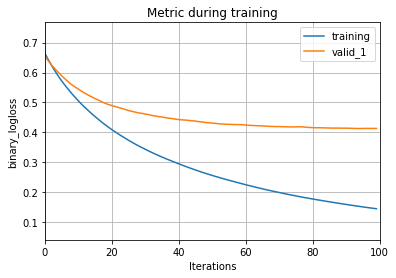

Plotting feature importances...


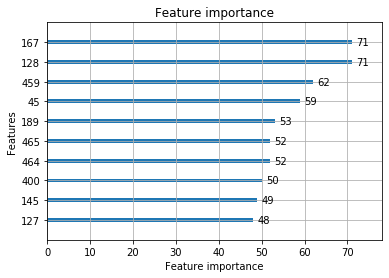

Training until validation scores don't improve for 5 rounds
[50]	training's binary_logloss: 0.254556	valid_1's binary_logloss: 0.468709
[100]	training's binary_logloss: 0.140889	valid_1's binary_logloss: 0.457039
Early stopping, best iteration is:
[108]	training's binary_logloss: 0.13037	valid_1's binary_logloss: 0.456642
Plotting metrics recorded during training...


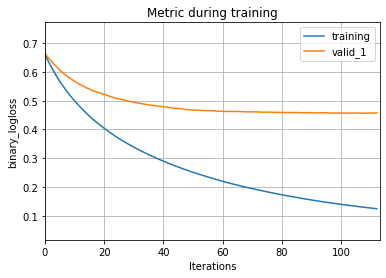

Plotting feature importances...


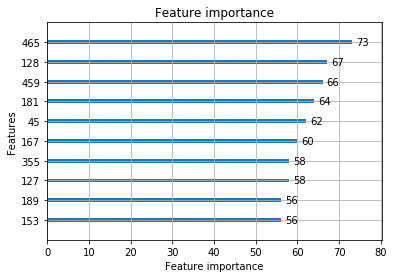

Training until validation scores don't improve for 5 rounds
[50]	training's binary_logloss: 0.248407	valid_1's binary_logloss: 0.486463
Early stopping, best iteration is:
[90]	training's binary_logloss: 0.149816	valid_1's binary_logloss: 0.470763
Plotting metrics recorded during training...


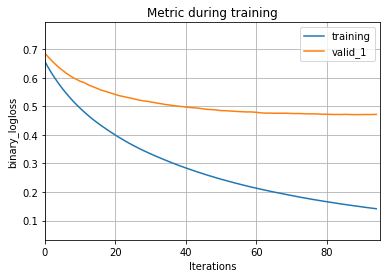

Plotting feature importances...


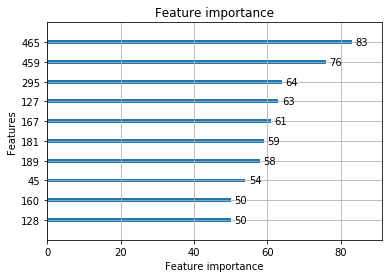

Training until validation scores don't improve for 5 rounds
[50]	training's binary_logloss: 0.256437	valid_1's binary_logloss: 0.464669
[100]	training's binary_logloss: 0.141518	valid_1's binary_logloss: 0.4398
Early stopping, best iteration is:
[111]	training's binary_logloss: 0.126845	valid_1's binary_logloss: 0.437033
Plotting metrics recorded during training...


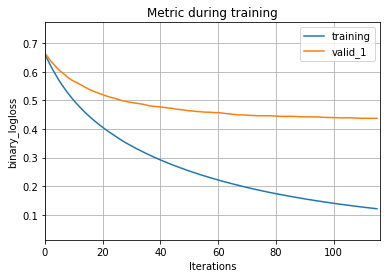

Plotting feature importances...


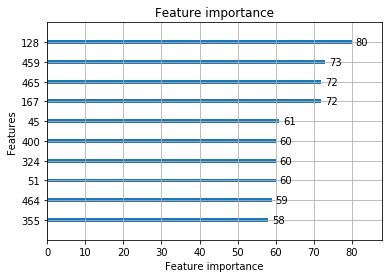

Training until validation scores don't improve for 5 rounds
[50]	training's binary_logloss: 0.258867	valid_1's binary_logloss: 0.439482
Early stopping, best iteration is:
[83]	training's binary_logloss: 0.173241	valid_1's binary_logloss: 0.422878
Plotting metrics recorded during training...


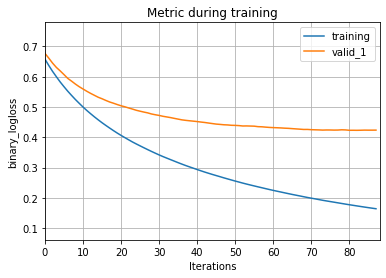

Plotting feature importances...


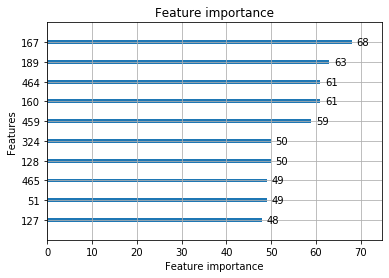

In [25]:
params = {
    'objective': 'binary',
    'feature_fraction': 0.9,
    'lambda_l1': 1.0,
    'lambda_l2': 0.001,
    'learning_rate': 0.05,
    'max_depth': -1,
    'n_estimators': 500,
    'num_leaves': 64,
    'metric': 'binary_logloss',
    'random_seed': 42
}

kf = KFold(n_splits=5, random_state=42)
models = []

X_train = pd.DataFrame(data=X_train_embed,columns=np.arange(1,513).tolist()+['URL','emoji','tag','have_keyword','have_location'])
y_train = train["target"]

for train_index, test_index in kf.split(X_train):
    train_features = X_train.loc[train_index]
    train_target = y_train.loc[train_index]

    test_features = X_train.loc[test_index]
    test_target = y_train.loc[test_index]

    d_training = lgb.Dataset(
        train_features, label=train_target, free_raw_data=False)
    d_test = lgb.Dataset(test_features, label=test_target, free_raw_data=False)

    evals_result = {}  # to record eval results for plotting

    model = lgb.train(
        params,
        train_set=d_training,
        num_boost_round=200,
        valid_sets=[d_training, d_test],
        verbose_eval=50,
        early_stopping_rounds=5,
        evals_result=evals_result)

    # https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/
    print('Plotting metrics recorded during training...')
    ax = lgb.plot_metric(evals_result, metric='binary_logloss')
    plt.show()
    
    print('Plotting feature importances...')
    ax = lgb.plot_importance(model, max_num_features=10)
    plt.show()
    models.append(model)

# NB

In [38]:
vect = CountVectorizer(stop_words='english',ngram_range=(1,1)).fit(train["text_cleaned"])
X_train_vectorized = add_feature(vect.transform(train["text_cleaned"]),train[['URL','emoji','tag','have_keyword','have_location']])

In [39]:
clfrNB = MultinomialNB()
grid_values = {'alpha': [0.1,1,3,5,10]}
grid_clf_f1 = GridSearchCV(clfrNB, param_grid = grid_values, scoring = 'f1',cv=5).fit(X_train_vectorized, train["target"])
print('Grid best parameter (max. f1 score): ', grid_clf_f1.best_params_)
print('Grid best score (f1 score): ', grid_clf_f1.best_score_)

In [18]:
clfrNB = MultinomialNB(alpha=3)
sample_submission = pd.read_csv(r'C:\Users\User\Dropbox\Kaggle\NLP with Disaster Tweets\sample_submission.csv')
sample_submission["target"] = clfrNB.predict(X_test_embed)
sample_submission.to_csv(r'C:\Users\User\Dropbox\Kaggle\NLP with Disaster Tweets\done\sample_submission_NB.csv', index=False)

array([0.66129032, 0.53217391, 0.55654762, 0.52262774, 0.61904762,
       0.625     , 0.67170953, 0.64630225, 0.70914127, 0.73352436])

# Check submission

In [206]:
sub1 = pd.read_csv(r'C:\Users\User\Dropbox\Kaggle\NLP with Disaster Tweets\done\sample_submission_tf&lgb.csv')
sub2 = pd.read_csv(r'C:\Users\User\Dropbox\Kaggle\NLP with Disaster Tweets\done\sample_submission_tf&lgb_5.csv')

In [207]:
sub2[sub1['target']!=sub2['target']]

,id,target
0,0,0
66,223,1
93,317,1
104,351,1
162,537,1
...,...,...
3088,10228,1
3126,10362,0
3129,10373,1
3181,10549,1


In [199]:
sub1[sub1['target']!=sub2['target']]

,id,target
25,87,0
85,292,0
104,351,0
112,374,1
157,515,1
...,...,...
3095,10242,0
3096,10248,1
3137,10404,0
3170,10512,0
